<a href="https://colab.research.google.com/github/MaralAminpour/ML-BME-UofA/blob/main/Week-11-COVID-chest-x-ray/deep_learning_covid19_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Chest X-Ray Image Classification

We will use this Kaggle dataset: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

This notebook is primarily based on code from these two sources:
https://www.coursera.org/learn/covid-19-detection-x-ray/home/info
https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial

Our objective will be to train a multiclass model to classify chest x-ray images into 4 classes:
- COVID-19
- Normal (healthy)
- Non-COVID infection
- Viral pneumonia

# Importing Libraries

The following commands can be used to install missing packages. You may need not need to use these, or may need different commands, depending on your installation. You won't need to use these on Colab.

In [1]:
#!pip install torchvision
#!pip install opencv-python

#With Anaconda install the packages torchvision and py-opencv

Next we will run all the imports we'll need.

In [2]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import seaborn as sns
import cv2
import copy
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tqdm.notebook as tqdm
from PIL import Image

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.1.1


Finally, we will set the device variable with a CUDA device if one is available, otherwise we'll use GPU. On Colab you can change the runtime type to T4 GPU if you want to use a GPU device.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

cpu


# Preprocess dataset

I've made a duplicate in GitHub of the Kaggle dataset here: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

This code will let you get all the data into Colab or other environments.

In [ ]:
!git clone https://github.com/SirTurtle/COVID-19_Radiography_Dataset.git

The following code uses the CV2 library to apply the masks to the images to generate new images with only the lung segments. The rest of the image will be black.

In [5]:
dataset_path = 'COVID-19_Radiography_Dataset'
dataset_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
segmented_dataset_path = 'Segmented_Dataset'

In [6]:
os.makedirs(segmented_dataset_path, exist_ok=True)
for label in dataset_labels:
    os.makedirs(os.path.join(segmented_dataset_path, label), exist_ok=True)
for label in dataset_labels:
    image_dir_path = os.path.join(dataset_path, label, 'images')
    mask_dir_path = os.path.join(dataset_path, label, 'masks')
    image_files = os.listdir(image_dir_path)
    for image_file in image_files:
        if not image_file.endswith('.png'):
            continue
        image_file_path = os.path.join(image_dir_path, image_file)
        mask_file_path = os.path.join(mask_dir_path, image_file)
        image = cv2.imread(image_file_path)
        image = cv2.resize(image, (256,256))
        mask = cv2.imread(mask_file_path)
        masked_image = image
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_image_path = os.path.join(segmented_dataset_path, label, image_file)
        cv2.imwrite(masked_image_path, masked_image)

Next we'll check the balance between the classes.

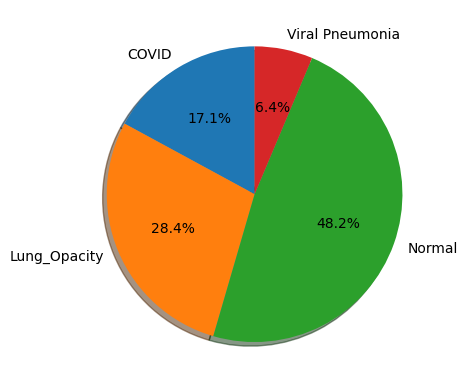

In [7]:
image_count = {}
for label in dataset_labels:
    image_count[label] = len(os.listdir(os.path.join(segmented_dataset_path, label)))

# Plotting the distribution of each class
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow = True,
        autopct = '%1.1f%%',
        startangle = 90)
plt.show()

Note that the "Lung_Opacity" class is non-COVID infection samples.

We should balance the classes. But for simplicity I will not do that here.

# Image Transformations

We will apply image transformations to our data using Torchvision. This will include our data augmentation, conversion to tensor and normalization.

The normalization values are selected to match the normalization applied for our pretrained weights. They are obtained from the documentation here:
https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights We are also resizing to 224 x 224 (in the pretrained model images are cropped to these dimensions, but I don't think cropping is appropriate for our data).

We will follow roughly the data augmentation used by Chowdhury et al.: rotation and translation. For rotation I set a max of 10 degrees (between 5 and 15 is what I saw used in different articles) and for translation 5%. Other transformations I've seen used are RandomHorizontalFlip but I decided not to use this transformation. The data augmentation will be applied only to the training set.

In [8]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomAffine(degrees=10, translate=(0.05,0.05)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=means, std=stds)
])

validation_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=means, std=stds)
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=means, std=stds)
])

# Create training, validation and test sets

We will create Torchvision DataLoader objects for each of the training, validation and test sets.

In [9]:
BATCH_SIZE = 8

def load_split_train_validation_test(path, validation_size=.1, test_size=.1):
    train_data = torchvision.datasets.ImageFolder(path,
                    transform=train_transform)
    validation_data = torchvision.datasets.ImageFolder(path,
                    transform=validation_transform)
    test_data = torchvision.datasets.ImageFolder(path,
                    transform=test_transform)
    num_train = len(train_data)
    indices = list(range(num_train))
    split_1 = int(np.floor((1 - validation_size - test_size) * num_train))
    split_2 = int(np.floor((1 - test_size) * num_train))
    np.random.shuffle(indices)
    train_idx, validation_idx, test_idx = indices[0:split_1], indices[split_1:split_2], indices[split_2:]
    dataset_size = {'train':len(train_idx), 'validation':len(validation_idx), 'test':len(test_idx)}
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    validation_sampler = torch.utils.data.sampler.SubsetRandomSampler(validation_idx)
    test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_idx)
    train_loader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=BATCH_SIZE)
    validation_loader = torch.utils.data.DataLoader(validation_data,
                   sampler=validation_sampler, batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=1)
    return train_loader, validation_loader, test_loader, dataset_size

train_loader, validation_loader, test_loader, dataset_size = \
    load_split_train_validation_test(segmented_dataset_path, .1, .1)
print(dataset_size)
data_loaders = {'train':train_loader, 'validation':validation_loader, 'test':test_loader}
data_sizes = {x: len(data_loaders[x].sampler) for x in ['train', 'validation', 'test']}
class_names = train_loader.dataset.classes
print(class_names)

{'train': 16932, 'validation': 2116, 'test': 2117}
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


# Data Visualization

Let's visualize our dataset now. We'll create a show_images function that will visualize a random batch of our dataset. This function will allow us to both visualize the images and to display the true and predicted labels. Since we don't have predicted labels yet we'll just use the true labels for both.

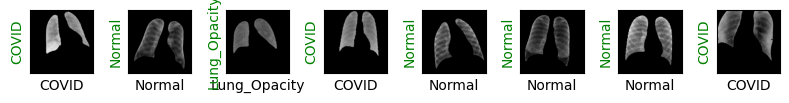

In [10]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, BATCH_SIZE, i + 1, xticks=[], yticks=[])
        image = image.to(torch.device('cpu'))
        labels = labels.to(torch.device('cpu'))
        preds = labels.to(torch.device('cpu'))
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array(means)
        std = np.array(stds)
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
show_images(images, labels, labels)

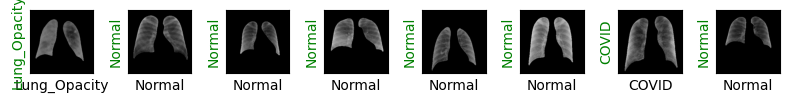

In [11]:
images, labels = next(iter(validation_loader))
show_images(images, labels, labels)

# Creating the Model

Now let's create our initial model. We'll be using resnet18. We will also load the pre-trained weights for resnet18 trained on the ImageNet1K dataset.

We will only modify the final layer for our 4 class problem. We won't be freezing any of the parameters.

If we want to use a different model, e.g. densenet121 or ChexNet, we would need to edit this code.

In [12]:
resnet18 = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=len(class_names))
resnet18 = resnet18.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-5)
_ = resnet18.to(device)

In [14]:
pytorch_total_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
11178564


We'll use the show_pred function to monitor our model during training.

In [15]:
def show_preds(model, images, labels):
    model.eval()
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

# Training the Model

We will use our validation set to implement an "early stopping" procedure. In this case, we will save the model if the loss on the validation set is improved compared with the previous epochs.

In [16]:
def train(model, epochs=1):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    print('Starting training..')

    for e in range(0, epochs):

        print(f'Starting epoch {e + 1}/{epochs}')

        val_loss = 0.

        model.train()

        for train_step, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            if train_step % 100 == 0:
                print('Running batch {}'.format(train_step))

        model.eval()

        for val_step, (images, labels) in enumerate(validation_loader):

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item() * images.size(0) # Multiplying by batch size

            val_loss /= (val_step + 1)

            if val_step % 100 == 0:
                show_preds(model, images, labels)

        epoch_loss = val_loss / data_sizes['validation'] # Dividing by total validation set size

        if epoch_loss < best_loss:
            print('Validation loss decreased from {} to {}'.format(best_loss, epoch_loss))
            print('...Saving weights')
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Training complete..')

    model.load_state_dict(best_model_wts)
    return model

Starting training..
Starting epoch 1/2
Running batch 0
Running batch 100
Running batch 200
Running batch 300
Running batch 400
Running batch 500
Running batch 600
Running batch 700
Running batch 800
Running batch 900
Running batch 1000
Running batch 1100
Running batch 1200
Running batch 1300
Running batch 1400
Running batch 1500
Running batch 1600
Running batch 1700
Running batch 1800
Running batch 1900
Running batch 2000
Running batch 2100


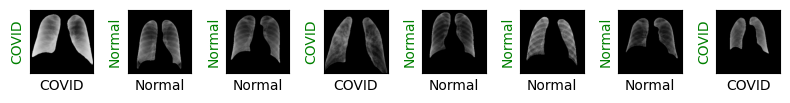

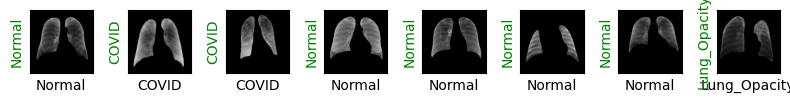

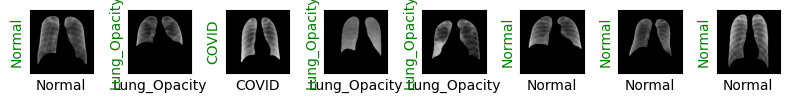

Validation loss decreased from inf to 0.000
...Saving weights
Starting epoch 2/2
Running batch 0
Running batch 100
Running batch 200
Running batch 300
Running batch 400
Running batch 500
Running batch 600
Running batch 700
Running batch 800
Running batch 900
Running batch 1000
Running batch 1100
Running batch 1200
Running batch 1300
Running batch 1400
Running batch 1500
Running batch 1600
Running batch 1700
Running batch 1800
Running batch 1900
Running batch 2000
Running batch 2100


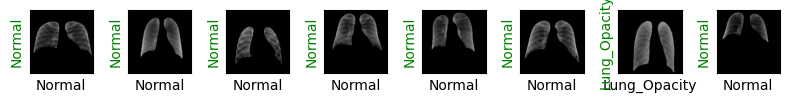

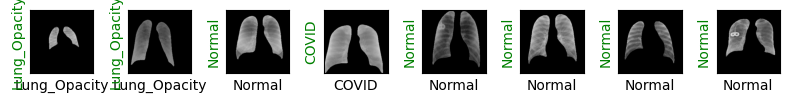

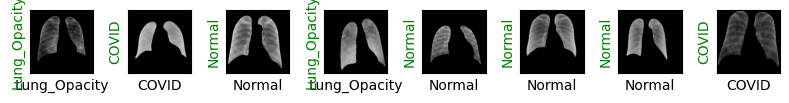

Validation loss decreased from 0.000 to 0.000
...Saving weights
Training complete..
CPU times: user 57min 5s, sys: 19min 17s, total: 1h 16min 22s
Wall time: 20min 19s


In [17]:
%%time

resnet18 = train(resnet18, epochs=2)

# Final Results

# Evaluating the Models

Next, we will print the classification report and display the confusion matrix.

  0%|          | 0/2117 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       378
           1       0.94      0.77      0.85       638
           2       0.90      0.96      0.93       979
           3       0.91      0.95      0.93       122

    accuracy                           0.88      2117
   macro avg       0.88      0.89      0.88      2117
weighted avg       0.89      0.88      0.88      2117



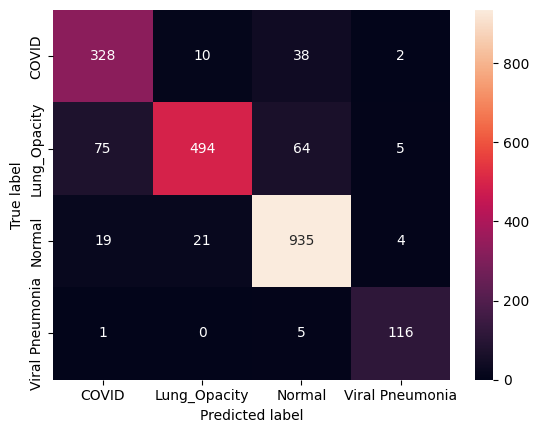

In [18]:
# Calculate the predicted and true labels

y_pred_list = []
y_true_list = []

with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(test_loader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = resnet18(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

# Calculate and print the classification report

print(classification_report(y_true_list, y_pred_list))

# Display the confusion matrix

heatmap = sns.heatmap(confusion_matrix(y_true_list, y_pred_list), annot=True, fmt='g')
heatmap.yaxis.set_ticklabels(class_names)
heatmap.xaxis.set_ticklabels(class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Saving the Model

In [19]:
torch.save(resnet18.state_dict(), 'covid_classifier_resnet18.pt')

# Inference on a Single Image

In [20]:
# Load the model and set in eval
resnet18 = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
resnet18.load_state_dict(torch.load('covid_classifier_resnet18.pt'))
resnet18.eval()

def predict_image_class(image_path):
    image = Image.open(image_path)
    image = test_transform(image)
    image = image.unsqueeze(0)
    image = image.to(torch.device('cpu'))
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

In [21]:
image_path = 'Segmented_Dataset/COVID/COVID-1.png'
probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [8.5150445e-01 1.4411937e-01 3.5272930e-03 8.4891258e-04]
Predicted class index: 0
Predicted class name: COVID


In [22]:
image_path = 'Segmented_Dataset/Lung_Opacity/Lung_Opacity-1.png'
#image_path = 'covid_data_small/test/viral/Viral_Pneumonia-201.png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [0.14016403 0.686403   0.16894422 0.00448879]
Predicted class index: 1
Predicted class name: Lung_Opacity


In [23]:
image_path = 'Segmented_Dataset/Normal/Normal-1.png'
#image_path = 'covid_data_small/test/normal/Normal-201.png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [6.6451885e-02 2.6056617e-02 9.0734416e-01 1.4733337e-04]
Predicted class index: 2
Predicted class name: Normal
